<a href="https://colab.research.google.com/github/EMockevicius/computer-vision/blob/main/blob_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Blob detection
example based on - https://projectsflix.com/opencv/laplacian-blob-detector-using-python/

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/Computer vision/blob_detection'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Computer vision/blob_detection
 1-162hrh2ax2.tif                               blob.png
 1-162hrhoe2.tif                                blob.tif
 A1--W00001--P00005--Z00000--T00000--DAPI.tif  'Copy of blob_detection.ipynb'
 AS_09125_050116030001_D03f00d0.tif             test_komp_rega_ld3.ipynb
 blob_detection.ipynb


In [5]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial

(Text(0.5, 1.0, 'initial image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>),
 <matplotlib.image.AxesImage at 0x7fc75844a850>)

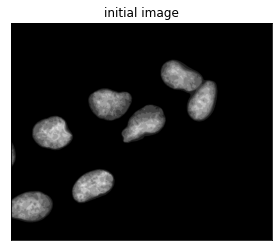

In [7]:
#img_file = '/content/drive/MyDrive/Colab Notebooks/Computer vision/blob_detection/A1--W00001--P00005--Z00000--T00000--DAPI.tif'
#img_file = '/content/drive/MyDrive/Colab Notebooks/Computer vision/blob_detection/AS_09125_050116030001_D03f00d0.tif'
img_file ='/content/drive/MyDrive/Colab Notebooks/Computer vision/blob_detection/1-162hrhoe2.tif'
#img_file ='/content/drive/MyDrive/Colab Notebooks/Computer vision/blob_detection/1-162hrh2ax2.tif'

img = cv2.imread(img_file,0) #gray scale conversion

k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

plt.title('initial image'), plt.xticks([]), plt.yticks([]), plt.imshow(img,cmap="gray")

In [8]:
def LoG(sigma): #Generating LoG filter which generates a filter of size 6*sigma from input
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) * (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter 

(9, 1002, 1202)


(Text(0.5, 1.0, 'image with LoG'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>),
 <matplotlib.image.AxesImage at 0x7fc758502a50>)

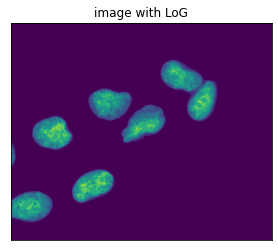

In [9]:
def LoG_convolve(img): #Convolving images with Gaussian Filters
    log_images = []
    for i in range(0,9): #using 9 filters
        y = np.power(k,i)
        sigma_1 = sigma*y #using different sigma than LoG
        filter_log = LoG(sigma_1) #generating a filter
        image = cv2.filter2D(img,-1,filter_log)# convolving image
        image = np.pad(image,((1,1),(1,1)),'constant')#padding 
        image = np.square(image) # squaring the response
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the numpy array
    return log_image_np

log_image_np = LoG_convolve(img)
print(log_image_np.shape)
plt.title('image with LoG'), plt.xticks([]), plt.yticks([]), plt.imshow(img)

In [10]:
def blob_overlap(blob1, blob2): #finding overlapping blobs
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob removed
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))

In [11]:
def redundancy(blobs_array, overlap): #removing redundant blobs
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])

In [12]:
!free -mh #check ram

              total        used        free      shared  buff/cache   available
Mem:            12G        1.4G        9.4G        1.2M        1.9G         11G
Swap:            0B          0B          0B


In [13]:
def detect_blob(log_image_np): #extremums
    #treshold = 0.1
    #treshold = 0.01
    #treshold = 0.001
    #treshold = 0.0001
    treshold = 0.00002 #lower treshold can cause ram issues 
    co_ordinates = [] #save blob coordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] #3x3 filter
            result = np.amax(slice_img) #finding maximum
            #print(result)
            if result >= treshold: # blob treshold
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) #find blob coordinates
    return co_ordinates

co_ordinates = list(set(detect_blob(log_image_np)))

if not co_ordinates:
  print("No blobs found, reduce the treshold")
  exit()
else:
  co_ordinates = np.array(co_ordinates)
  co_ordinates = redundancy(co_ordinates,0.5)


In [ ]:
print(co_ordinates)

In [14]:
print("number of blobs: ", co_ordinates.size/3)

number of blobs:  67.0


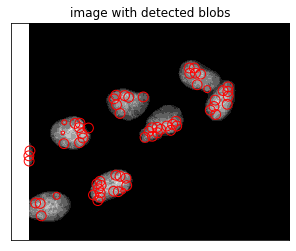

In [15]:
fig, ax = plt.subplots() #results
nh,nw = img.shape

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1, fill=False)
    ax.add_patch(c)
ax.plot()  

plt.title('image with detected blobs'), plt.xticks([]), plt.yticks([]), plt.show()
fig.savefig("blob.png", bbox_inches = 'tight',pad_inches = 0)